<a href="https://colab.research.google.com/github/mnslarcher/critical-facts-that-every-data-scientist-should-know/blob/main/part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Critical Facts That Every Data Scientist Should Know - Part 2

In [1]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import ArrayLike
from scipy.interpolate import CubicSpline
from sklearn.datasets import make_blobs
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    f1_score,
    mean_absolute_error,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split

np.random.seed(42)

## Data Leakage, When Your Results Are Too Good to Be True

In [2]:
X, y = make_blobs(n_samples=[5500, 5500], centers=[[0.0, 0.0], [1.0, 1.0]])

# updated_last_year is 1 with prob. 0.1 if the customer has not committed fraud in the last year
updated_last_year = np.random.binomial(1, 0.1, size=(len(X), 1))
# updated_last_year is always 1 if the customer has committed fraud in the last year
updated_last_year[y.astype(bool)] = 1.0

X = np.hstack([X, updated_last_year])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000)

clf = LogisticRegression().fit(X_train, y_train)

In [3]:
test_pred = clf.predict(X_test)

precision = precision_score(y_test, test_pred)
recall = recall_score(y_test, test_pred)
f1 = f1_score(y_test, test_pred)
print(f"Test precision: {100 * precision:.2f}%")
print(f"Test recall: {100 * recall:.2f}%")
print(f"Test F1-score: {100 * f1:.2f}%")

Test precision: 89.95%
Test recall: 99.40%
Test F1-score: 94.44%


In [4]:
X_prod, y_prod = make_blobs(n_samples=[500, 500], centers=[[0, 0], [1, 1]])
updated_last_year = np.random.binomial(1, 0.10, size=(len(X_prod), 1))
X_prod = np.hstack([X_prod, updated_last_year])

prod_pred = clf.predict(X_prod)

precision = precision_score(y_prod, prod_pred)
recall = recall_score(y_prod, prod_pred)
f1 = f1_score(y_prod, prod_pred)
print(f"Production precision: {100 * precision:.2f}%")
print(f"Production recall: {100 * recall:.2f}%")
print(f"Production F1-score: {100 * f1:.2f}%")

Production precision: 47.37%
Production recall: 9.00%
Production F1-score: 15.13%


## Interpretability and Simpson's Paradox

In [5]:
def get_salary(age: np.ndarray) -> np.ndarray:
    return 1.1 * age + 2.0 * np.random.normal(size=len(age))


def get_health_index(age: np.ndarray, salary: np.ndarray) -> np.ndarray:
    return salary - 2.0 * age + 100.0 + np.random.normal(size=len(age))


def make_simpson(age: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    salary = get_salary(age)
    X = np.c_[salary, age]
    y = get_health_index(age, salary)
    return X, y

> Note: the the following plots are inspired by [Pace~svwiki](https://en.wikipedia.org/wiki/Simpson%27s_paradox#/media/File:Simpsons_paradox_-_animation.gif).

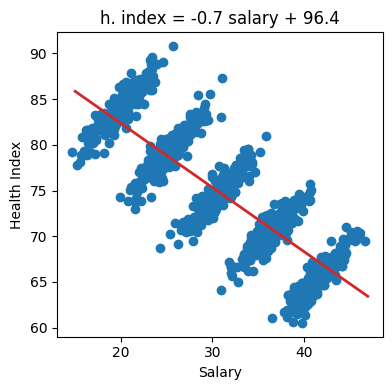

In [6]:
X, y = make_simpson(np.random.choice(np.arange(18, 39, 5), size=1000))
X_salary = X[:, [0]]

reg = LinearRegression().fit(X_salary, y)

X_test = np.arange(15, 48).reshape(-1, 1)
y_pred = reg.predict(X_test)

plt.figure(dpi=100)
plt.title(f"h. index = {reg.coef_[0]:.1f} salary + {reg.intercept_:.1f}")
plt.scatter(X[:, 0], y)
plt.plot(X_test, y_pred, c="tab:red", lw=2)
plt.xlabel("Salary")
plt.ylabel("Health Index")
plt.tight_layout()
plt.gca().set_aspect("equal")
plt.savefig("fig2.png")
plt.show()

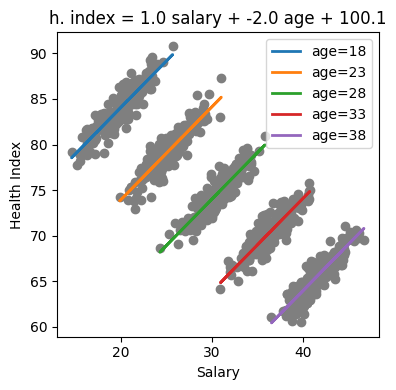

In [7]:
reg = LinearRegression().fit(X, y)

plt.figure(dpi=100)
plt.title(f"h. index = {reg.coef_[0]:.1f} salary + {reg.coef_[1]:.1f} age + {reg.intercept_:.1f}")

for age in np.arange(18, 39, 5):
    X_age = X[X[:, 1] == age]
    y_age = reg.predict(X_age)
    plt.plot(X_age[:, 0], y_age, lw=2, label=f"age={age}")

plt.scatter(X[:, 0], y, c="tab:gray")
plt.xlabel("Salary")
plt.ylabel("Health Index")
plt.legend()
plt.tight_layout()
plt.gca().set_aspect("equal")
plt.savefig("fig3.png")
plt.show()

## How Sampling Bias Affects Your Model

In [8]:
def make_private_vs_state(
    private_n_samples: ArrayLike = [8000, 2000], state_n_samples: ArrayLike = [9500, 500]
) -> Tuple[np.ndarray, np.ndarray]:
    X_private, y_private = make_blobs(n_samples=private_n_samples, centers=[[0, 5], [0, 5]])
    X_state, y_state = make_blobs(n_samples=state_n_samples, centers=[[10, 0], [10, 0]])
    is_state = np.hstack([np.zeros(len(X_private), dtype=bool), np.ones(len(X_state), dtype=bool)])
    X = np.hstack([np.vstack([X_private, X_state]), is_state.reshape(-1, 1)])
    y = np.hstack([y_private, y_state])
    return X, y

In [9]:
X, y = make_private_vs_state()

is_private = X[:, 2] == 0
is_state = X[:, 2] == 1

is_normal = y == 0
is_fraud = y == 1

is_private_and_normal = is_private & is_normal
is_private_and_fraud = is_private & is_fraud
is_state_and_normal = is_state & is_normal
is_state_and_fraud = is_state & is_fraud

insp_prob = is_private_and_normal * 0.1 + is_private_and_fraud * 0.4 + is_state_and_normal * 0.01 + is_state_and_fraud * 0.3
is_insp = np.array([np.random.binomial(1, p) == 1 for p in insp_prob])
X_insp = X[is_insp]
y_insp = y[is_insp]

is_private_and_normal_and_insp = is_private_and_normal & is_insp
is_private_and_fraud_and_insp = is_private_and_fraud & is_insp
is_state_and_normal_and_insp = is_state_and_normal & is_insp
is_state_and_fraud_and_insp = is_state_and_fraud & is_insp
num_insp = is_insp.sum()

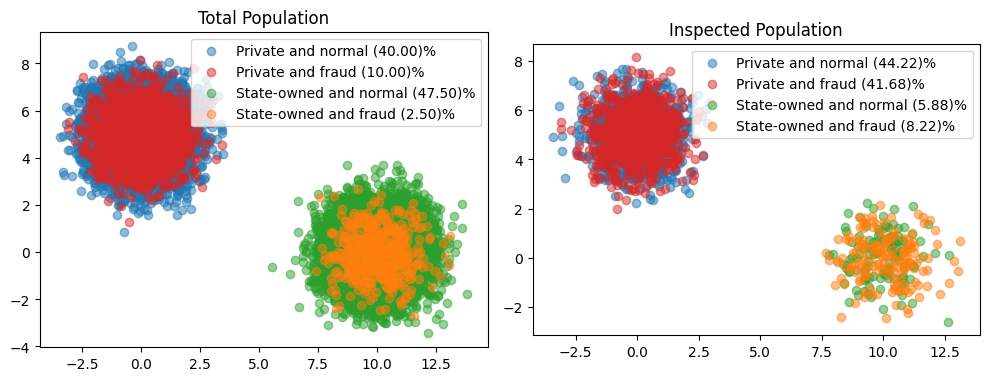

In [10]:
plt.figure(figsize=(10, 4), dpi=100)

ax1 = plt.subplot(121)
plt.title("Total Population")
plt.scatter(*X[is_private_and_normal, :2].T, c="tab:blue", alpha=0.5, label=f"Private and normal ({100 * is_private_and_normal.mean():.2f})%")
plt.scatter(*X[is_private_and_fraud, :2].T, c="tab:red", alpha=0.5, label=f"Private and fraud ({100 * is_private_and_fraud.mean():.2f})%")
plt.scatter(*X[is_state_and_normal, :2].T, c="tab:green", alpha=0.5, label=f"State-owned and normal ({100 * is_state_and_normal.mean():.2f})%")
plt.scatter(*X[is_state_and_fraud, :2].T, c="tab:orange", alpha=0.5, label=f"State-owned and fraud ({100 * is_state_and_fraud.mean():.2f})%")
plt.legend(loc="upper right")
ax1.set_aspect("equal")

ax2 = plt.subplot(122)
plt.title("Inspected Population")
plt.scatter(*X[is_private_and_normal_and_insp, :2].T, c="tab:blue", alpha=0.5, label=f"Private and normal ({100 * is_private_and_normal_and_insp.sum() / num_insp:.2f})%")
plt.scatter(*X[is_private_and_fraud_and_insp, :2].T, c="tab:red", alpha=0.5, label=f"Private and fraud ({100 * is_private_and_fraud_and_insp.sum() / num_insp:.2f})%")
plt.scatter(*X[is_state_and_normal_and_insp, :2].T, c="tab:green", alpha=0.5, label=f"State-owned and normal ({100 * is_state_and_normal_and_insp.sum() / num_insp:.2f})%")
plt.scatter(*X[is_state_and_fraud_and_insp, :2].T, c="tab:orange", alpha=0.5, label=f"State-owned and fraud ({100 * is_state_and_fraud_and_insp.sum() / num_insp:.2f})%")
plt.legend(loc="upper right")
ax2.set_aspect("equal")

plt.tight_layout()
plt.savefig("fig4.png")
plt.show()

In [11]:
def get_top_k(x: ArrayLike, score: ArrayLike, k: int) -> ArrayLike:
    idx = np.argsort(score)
    return x[idx][-k:]

In [12]:
X_prod, y_prod = make_private_vs_state()

is_private = X_prod[:, 2] == 0
is_state = X_prod[:, 2] == 1

is_normal = y_prod == 0
is_fraud = y_prod == 1

prod_score = clf.predict_proba(X_prod)[:, 1]

k = 1000
perc_state_in_top_k = get_top_k(is_state, prod_score, k).sum() / k

print(f"Percentage of state-owned enterprises: {100 * is_state.mean():.2f}%")
print(f"Percentage of private enterprises: {100 * is_private.mean():.2f}%")
print(f"Fraud rate in state-owned enterprises: {100 * y_prod[is_state].mean():.2f}%")
print(f"Fraud rate in private enterprises: {100 * y_prod[is_private].mean():.2f}%")
print(f"Percentage of state-owned enterprises in the top {k} to be inspected: {100 * perc_state_in_top_k:.2f}%")

Percentage of state-owned enterprises: 50.00%
Percentage of private enterprises: 50.00%
Fraud rate in state-owned enterprises: 5.00%
Fraud rate in private enterprises: 20.00%
Percentage of state-owned enterprises in the top 1000 to be inspected: 100.00%


## Non-Stationarity and Covariate Shift

In [13]:
def make_temperature_vs_relative_growth_rate(low: float, high: float, size: int = 100) -> np.ndarray:
    def _first_linear_part(temperature: np.ndarray) -> np.ndarray:
        return 0.014 * temperature + 0.1

    def _second_linear_part(temperature: np.ndarray) -> np.ndarray:
        return -0.1 * temperature + 4.0

    x_first = np.linspace(-10, 30)
    y_first = _first_linear_part(x_first)
    x_second = np.linspace(35, 40)
    y_second = _second_linear_part(x_second)
    x = np.hstack([x_first, np.array([32]), x_second])
    y = np.hstack([y_first, np.array([0.55]), y_second])
    cs = CubicSpline(x, y)

    temperature = np.random.uniform(low, high, size=size)
    relative_growth_rate = cs(temperature) + np.random.normal(scale=0.01, size=size)
    temperature += np.random.normal(scale=1, size=size)
    return temperature[:, None], relative_growth_rate

In [14]:
X_train, y_train = make_temperature_vs_relative_growth_rate(0, 30)
reg = LinearRegression().fit(X_train, y_train)

In [15]:
X_test, y_test = make_temperature_vs_relative_growth_rate(0, 30)

test_pred = reg.predict(X_test)

mae = mean_absolute_error(y_test, test_pred)
print(f"First period mean absolute error: {mae:.2f}")

First period mean absolute error: 0.01


In [16]:
X_ood, y_ood = make_temperature_vs_relative_growth_rate(30, 40)

ood_pred = reg.predict(X_ood)

mae = mean_absolute_error(y_ood, ood_pred)
print(f"Second period mean absolute error: {mae:.2f}")

Second period mean absolute error: 0.18


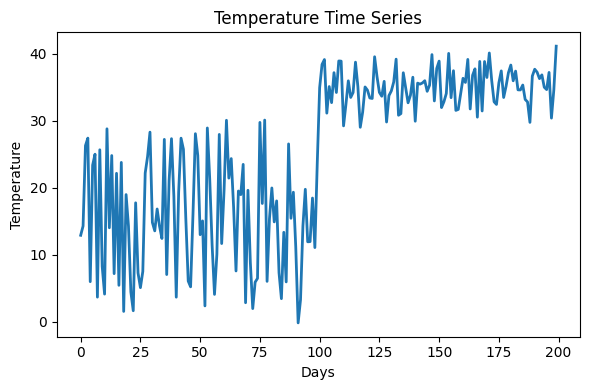

In [17]:
temperature = np.vstack([X_test, X_ood]).flatten()
days = np.arange(len(temperature))

plt.figure(dpi=100)
plt.title("Temperature Time Series")
plt.plot(days, temperature, lw=2)
plt.xlabel("Days")
plt.ylabel("Temperature")
plt.tight_layout()
plt.savefig("fig5.png")
plt.show()

> Note: the following plot is inspired by [Criddle et al. 2005](https://www.researchgate.net/figure/Schematic-plots-of-plant-growth-rate-vs-temperature-for-plants-adapted-to-near-constant_fig2_228690105).

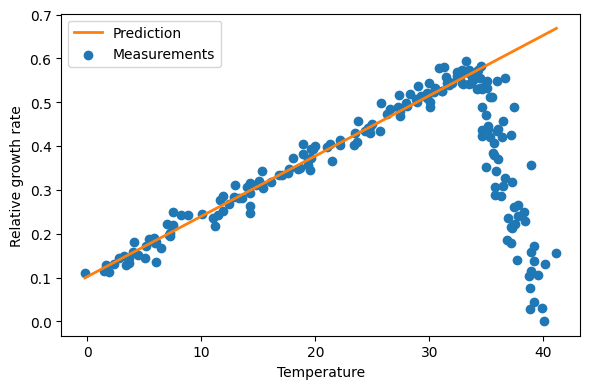

In [18]:
relative_growth_rate = np.hstack([y_test, y_ood])
y_pred = np.hstack([test_pred, ood_pred])
idx = np.argsort(temperature)

plt.figure(dpi=100)
plt.scatter(temperature, relative_growth_rate, label="Measurements")
plt.plot(temperature[idx], y_pred[idx], c="tab:orange", lw=2, label="Prediction")
plt.legend()
plt.xlabel("Temperature")
plt.ylabel("Relative growth rate")
plt.tight_layout()
plt.savefig("fig6.png")
plt.show()

## Observer Effect and Concept Drift



In [19]:
def prod_vs_illum(productivity: np.ndarray, illum_increase: bool, aware_of_being_obs: bool) -> np.ndarray:
    size = len(productivity)
    multiplier = np.random.normal(1.50, 0.05, size=size) if aware_of_being_obs else np.random.normal(1.0, 0.05, size=size)
    return productivity * multiplier

In [20]:
productivity = np.random.normal(50.0, 10.0, size=1000)

normal_illum = (prod_vs_illum(productivity, False, False) - productivity) / productivity
increased_illum_aware = (prod_vs_illum(productivity, True, True) - productivity) / productivity

print(f"Productivity increase - normal illumination: {100 * normal_illum.mean():.1f}% ± {100 * normal_illum.std():.1f}% (mean ± std. dev.)")
print(f"Productivity increase - increased illumination: {100 * increased_illum_aware.mean():.1f}% ± {100 * increased_illum_aware.std():.1f}% (mean ± std. dev.)")

Productivity increase - normal illumination: 0.1% ± 5.0% (mean ± std. dev.)
Productivity increase - increased illumination: 50.1% ± 4.9% (mean ± std. dev.)


In [21]:
increased_illum_not_aware = (prod_vs_illum(productivity, True, False) - productivity) / productivity

print(f"Productivity increase - increased illumination and aware: {100 * increased_illum_aware.mean():.1f}% ± {100 * increased_illum_aware.std():.1f}% (mean ± std. dev.)")
print(f"Productivity increase - increased illumination and not aware: {100 * increased_illum_not_aware.mean():.1f}% ± {100 * increased_illum_not_aware.std():.1f}% (mean ± std. dev.)")

Productivity increase - increased illumination and aware: 50.1% ± 4.9% (mean ± std. dev.)
Productivity increase - increased illumination and not aware: -0.2% ± 5.0% (mean ± std. dev.)
